<a href="https://colab.research.google.com/github/Carlosrnes/Nova_NLP/blob/main/NLP_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### GPU

In [1]:
# Check GPU
!nvidia-smi -L

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [2]:
# A dependency of the preprocessing for BERT inputs
!pip install -q -U "tensorflow-text==2.8.*"

     |████████████████████████████████| 4.9 MB 4.3 MB/s 


### Libraries

In [82]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from bs4 import BeautifulSoup


import tensorflow_hub as hub
import tensorflow as tf
import tensorflow_text as text
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras import layers

### Get the data

In [4]:
train_df = pd.read_csv("https://raw.githubusercontent.com/Carlosrnes/Nova_NLP/main/data/training_set.txt", sep="\t")
valid_df = pd.read_csv("https://raw.githubusercontent.com/Carlosrnes/Nova_NLP/main/data/dev_set.txt", sep="\t")
test_df = pd.read_csv("https://raw.githubusercontent.com/Carlosrnes/Nova_NLP/main/data/test_set.txt", sep="\t")
train_df.head(1)

,sentence,emotion
0,I'm too old to be traded in .,6


### Explore Dataset

In [83]:
# check if the emotions are correctly defined:
print(np.sort(train_df['emotion'].unique()))

# check the distribution of sentences in each emotion class:
df = train_df.groupby('emotion').count().reset_index()
sum_total = df['sentence'].sum()
df['perc_total'] = round(df['sentence']/sum_total,2)
df['dataset'] = 'Train'
df

[1 2 3 4 5 6 7 8]


,emotion,sentence,perc_total,dataset
0,1,2999,0.21,Train
1,2,2129,0.15,Train
2,3,1343,0.10,Train
3,4,1442,0.10,Train
4,5,1470,0.10,Train
5,6,1384,0.10,Train
6,7,1138,0.08,Train
7,8,2095,0.15,Train


In [6]:
# Samples
print(f"Total training samples: {len(train_df)}")
print(f"Total valid samples: {len(valid_df)}")
print(f"Total samples: {len(train_df) + len(valid_df)}")

Total training samples: 14000
Total valid samples: 1000
Total samples: 15000


### Transform training, validation and test sets to Numpy

In [7]:
# Transform to numpy
train_sentences = train_df["sentence"].to_numpy()
val_sentences = valid_df["sentence"].to_numpy()
test_sentences = test_df["sentence"].to_numpy()
train_labels = train_df["emotion"].to_numpy()
val_labels = valid_df["emotion"].to_numpy()


# Check the lengths
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels), len(test_sentences)

(14000, 14000, 1000, 1000, 2000)

### Tokenization

In [8]:
# The default TextVectorization variables
text_vectorizer = TextVectorization(max_tokens=None,
                                    standardize="lower_and_strip_punctuation", 
                                    split="whitespace", 
                                    ngrams=None, 
                                    output_mode="int", 
                                    output_sequence_length=None) 

In [9]:
# Average number of tokens (words) in training set
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

9

In [10]:
# Setup text vectorization with custom variables
max_vocab_length = 10000
max_length = 9

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

In [11]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

In [13]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(words_in_vocab)}")

Number of words in vocab: 7656


In [14]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'batch_input_shape': (None,),
 'dtype': 'string',
 'idf_weights': None,
 'max_tokens': 10000,
 'name': 'text_vectorization_1',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 9,
 'pad_to_max_tokens': False,
 'ragged': False,
 'sparse': False,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True,
 'vocabulary': None}

### Embedding

In [15]:
tf.random.set_seed(42)

embedding = layers.Embedding(input_dim=max_vocab_length, # set input shape
                             output_dim=128, # set size of embedding vector
                             embeddings_initializer="uniform", # default, intialize randomly
                             input_length=max_length, # how long is each input
                             name="embedding_1") 

embedding

In [16]:
# One hot encode labels
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_labels.reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_labels.reshape(-1, 1))

# Check what training labels look like
train_labels_one_hot

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

In [17]:
# Turn data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))

train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(8,), dtype=tf.float64, name=None))>

In [18]:
# Take the TensorSliceDataset's and turn them into prefetched batches
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 8), dtype=tf.float64, name=None))>

### Create Models

In [19]:
# Function to evaluate: accuracy, precision, recall, f1-score

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
  -----
  y_true = true labels in the form of a 1D array
  y_pred = predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

#### Model 1 - A simple dense model

In [21]:
# Create 1D convolutional model to process sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs) # vectorize text inputs
token_embeddings = embedding(text_vectors) # create embedding
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) # condense the output of our feature vector
outputs = layers.Dense(8, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

# Compile
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [22]:
# Compile model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [23]:
# Get a summary of the model
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 9)                0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 9, 128)            1280000   
                                                                 
 conv1d_1 (Conv1D)           (None, 9, 64)             41024     
                                                                 
 global_average_pooling1d_1   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_1 (Dense)             (None, 8)                 520 

In [24]:
# Fit the model
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch=int(len(train_dataset)),
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(len(valid_dataset))) 

Epoch 1/3
438/438 [==============================] - 9s 19ms/step - loss: 1.9132 - accuracy: 0.2691 - val_loss: 1.7537 - val_accuracy: 0.3450
Epoch 2/3
438/438 [==============================] - 11s 26ms/step - loss: 1.5532 - accuracy: 0.4447 - val_loss: 1.7303 - val_accuracy: 0.3680
Epoch 3/3
438/438 [==============================] - 8s 18ms/step - loss: 1.2585 - accuracy: 0.5712 - val_loss: 1.8489 - val_accuracy: 0.3580


In [26]:
# Make predictions
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs

array([[0.00626481, 0.4646798 , 0.00105936, ..., 0.00600373, 0.00110734,
        0.3029902 ],
       [0.12706798, 0.01540407, 0.01945466, ..., 0.22267945, 0.01150236,
        0.04801081],
       [0.0071745 , 0.01869232, 0.00627803, ..., 0.02078598, 0.04715654,
        0.06799088],
       ...,
       [0.5657352 , 0.16235632, 0.04181686, ..., 0.00593888, 0.06582469,
        0.06314001],
       [0.07235826, 0.09307036, 0.19771759, ..., 0.10811728, 0.1338463 ,
        0.08541854],
       [0.12805837, 0.21253675, 0.02291073, ..., 0.04287555, 0.04044146,
        0.27434576]], dtype=float32)

In [27]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1) + 1
model_1_preds

<tf.Tensor: shape=(1000,), dtype=int64, numpy=
array([2, 4, 5, 2, 1, 1, 2, 3, 1, 5, 5, 6, 1, 8, 2, 1, 2, 1, 1, 3, 5, 5,
       3, 1, 1, 8, 5, 4, 2, 2, 2, 5, 5, 2, 6, 4, 1, 8, 8, 2, 2, 4, 1, 1,
       1, 2, 1, 1, 5, 8, 2, 2, 5, 5, 6, 8, 1, 3, 1, 3, 1, 7, 1, 8, 6, 8,
       2, 8, 8, 2, 1, 6, 6, 8, 5, 2, 8, 1, 4, 7, 2, 1, 5, 8, 8, 4, 1, 8,
       5, 2, 2, 1, 3, 2, 8, 1, 4, 1, 1, 5, 4, 8, 2, 1, 6, 7, 8, 7, 5, 7,
       1, 8, 1, 1, 6, 8, 5, 5, 5, 7, 5, 8, 2, 2, 7, 2, 3, 2, 2, 8, 2, 3,
       1, 3, 4, 1, 1, 2, 1, 2, 2, 5, 5, 7, 8, 8, 5, 6, 1, 4, 8, 8, 7, 1,
       1, 2, 3, 5, 4, 1, 6, 2, 4, 3, 8, 2, 2, 5, 3, 3, 2, 2, 2, 1, 1, 6,
       8, 7, 1, 6, 5, 5, 7, 8, 2, 8, 8, 8, 8, 7, 6, 6, 6, 4, 2, 2, 2, 8,
       1, 8, 1, 8, 1, 3, 1, 5, 8, 2, 1, 3, 5, 3, 5, 8, 6, 1, 2, 2, 1, 3,
       2, 4, 7, 7, 5, 3, 8, 8, 8, 8, 2, 4, 2, 1, 2, 5, 6, 7, 2, 8, 4, 1,
       8, 2, 2, 6, 4, 5, 8, 8, 2, 6, 7, 7, 1, 4, 4, 2, 7, 1, 3, 1, 1, 4,
       5, 8, 4, 2, 2, 8, 1, 6, 2, 1, 1, 2, 1, 3, 8, 1, 1, 1, 1, 8, 8, 8,
    

In [28]:
# Calculate model_1 results
model_1_results = calculate_results(y_true=val_labels,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 35.8,
 'f1': 0.3542043814510458,
 'precision': 0.3559899578204556,
 'recall': 0.358}

#### Model 2 - Feature extraction with pretrained token embeddings - Universal Sentence Encoder

In [29]:
# Download pretrained TensorFlow Hub universal sentence encoder

tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [31]:
# Define feature extractor model using TF Hub layer
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs) # tokenize text and create embedding
x = layers.Dense(128, activation="relu")(pretrained_embedding) # add a fully connected layer on top of the embedding
x = layers.Dense(128, activation="relu")(x) # add a fully connected layer on top of the embedding
outputs = layers.Dense(8, activation="softmax")(x) # create the output layer
model_2 = tf.keras.Model(inputs=inputs,
                        outputs=outputs)

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary of the model
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_2 (Dense)             (None, 128)               65664     
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 dense_4 (Dense)             (None, 8)                 1032      
                                                                 
Total params: 256,881,032
Trainable params: 83,208
Non-trainable params: 256,797,824
________________________________________

In [32]:
# Fit feature extractor model for 3 epochs
model_2.fit(train_dataset,
            steps_per_epoch=int(len(train_dataset)),
            epochs=3,
            validation_data=valid_dataset,
            validation_steps=int(len(valid_dataset)))

Epoch 1/3
438/438 [==============================] - 8s 11ms/step - loss: 1.6562 - accuracy: 0.3877 - val_loss: 1.5460 - val_accuracy: 0.4310
Epoch 2/3
438/438 [==============================] - 4s 10ms/step - loss: 1.4819 - accuracy: 0.4616 - val_loss: 1.5360 - val_accuracy: 0.4420
Epoch 3/3
438/438 [==============================] - 6s 13ms/step - loss: 1.4352 - accuracy: 0.4814 - val_loss: 1.5347 - val_accuracy: 0.4510


In [34]:
# Make predictions with feature extraction model
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

array([[0.03760057, 0.22206317, 0.01659917, ..., 0.02821268, 0.01342272,
        0.09768453],
       [0.06799753, 0.08150388, 0.08451717, ..., 0.30833232, 0.07957009,
        0.15709408],
       [0.03453704, 0.03538954, 0.02125585, ..., 0.10010757, 0.4776975 ,
        0.07206474],
       ...,
       [0.7458584 , 0.07302288, 0.01073778, ..., 0.00408832, 0.00973787,
        0.08324195],
       [0.06472748, 0.54124004, 0.0148844 , ..., 0.01928284, 0.19280753,
        0.09082155],
       [0.0754981 , 0.33410728, 0.02126292, ..., 0.01087739, 0.06760689,
        0.10978047]], dtype=float32)

In [35]:
# Convert the predictions with feature extraction model to classes
model_2_preds = tf.argmax(model_2_pred_probs, axis=1) + 1
model_2_preds

<tf.Tensor: shape=(1000,), dtype=int64, numpy=
array([4, 6, 7, 1, 1, 3, 1, 1, 6, 5, 8, 5, 1, 8, 2, 8, 8, 1, 1, 1, 5, 5,
       8, 1, 1, 8, 5, 5, 2, 2, 2, 7, 8, 2, 4, 6, 4, 5, 8, 2, 6, 5, 6, 1,
       2, 8, 2, 7, 5, 1, 1, 2, 5, 5, 6, 6, 2, 6, 2, 6, 1, 2, 3, 8, 3, 1,
       8, 8, 4, 8, 7, 8, 6, 4, 7, 2, 4, 2, 2, 2, 2, 1, 5, 6, 4, 6, 1, 1,
       2, 8, 2, 8, 4, 2, 8, 1, 4, 4, 1, 8, 1, 1, 3, 1, 6, 1, 1, 7, 7, 7,
       8, 8, 1, 2, 1, 5, 5, 5, 4, 1, 2, 3, 2, 4, 7, 2, 1, 5, 7, 1, 5, 6,
       1, 2, 8, 1, 1, 1, 1, 2, 5, 2, 1, 1, 8, 8, 8, 6, 1, 6, 8, 8, 5, 1,
       1, 2, 7, 1, 5, 1, 6, 2, 1, 6, 4, 1, 2, 5, 3, 7, 2, 2, 7, 1, 1, 1,
       2, 6, 3, 6, 2, 5, 7, 3, 4, 8, 5, 5, 8, 5, 4, 2, 6, 4, 5, 8, 1, 7,
       1, 8, 1, 2, 1, 1, 1, 1, 8, 1, 2, 6, 5, 1, 2, 8, 5, 1, 2, 7, 1, 3,
       2, 2, 5, 1, 2, 2, 8, 1, 8, 2, 2, 4, 2, 1, 2, 5, 6, 7, 1, 3, 4, 1,
       3, 1, 2, 1, 3, 5, 8, 1, 2, 6, 7, 6, 1, 4, 6, 5, 2, 1, 3, 2, 1, 4,
       3, 6, 4, 8, 2, 8, 1, 6, 2, 2, 2, 2, 1, 2, 8, 8, 1, 1, 1, 1, 2, 8,
    

In [36]:
# Calculate results from TF Hub pretrained embeddings results on validation set
model_2_results = calculate_results(y_true=val_labels,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 45.1,
 'f1': 0.4433250914779949,
 'precision': 0.449038891717879,
 'recall': 0.451}

#### Model 3 - Conv1D with character embeddings

In [37]:
# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]

print(train_chars[0])

I ' m   t o o   o l d   t o   b e   t r a d e d   i n   .


In [38]:
# Average character length
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

39.99371428571428

In [39]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

86

In [40]:
# Get all keyboard characters for char-level embedding
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [41]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # num characters in alphabet + space + OOV token
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,  
                                    output_sequence_length=output_seq_char_len,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")

# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)

In [42]:
# Check character vocabulary characteristics
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")

Number of different characters in character vocab: 45


In [43]:
# Create char embedding layer
char_embed = layers.Embedding(input_dim=NUM_CHAR_TOKENS, # number of different characters
                              output_dim=25, # embedding dimension of each character (same as Figure 1 in https://arxiv.org/pdf/1612.05251.pdf)
                              mask_zero=False, 
                              name="char_embed")

In [44]:
# Make Conv1D on chars only
inputs = layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(8, activation="softmax")(x)
model_3 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_3_conv1D_char_embedding")

# Compile model
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Check the summary of conv1d_char_model
model_3.summary()

Model: "model_3_conv1D_char_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 86)               0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 86, 25)            1750      
                                                                 
 conv1d_2 (Conv1D)           (None, 86, 64)            8064      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_5 (Dense)             (None, 8

In [45]:
# Create char datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 8), dtype=tf.float64, name=None))>

In [46]:
# Fit the model on chars only
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(len(val_char_dataset)))

Epoch 1/3
438/438 [==============================] - 6s 13ms/step - loss: 2.0164 - accuracy: 0.2138 - val_loss: 1.9776 - val_accuracy: 0.2280
Epoch 2/3
438/438 [==============================] - 5s 12ms/step - loss: 1.9485 - accuracy: 0.2577 - val_loss: 1.9184 - val_accuracy: 0.2830
Epoch 3/3
438/438 [==============================] - 7s 16ms/step - loss: 1.8842 - accuracy: 0.2879 - val_loss: 1.8865 - val_accuracy: 0.2970


In [47]:
# Make predictions with character model only
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

array([[0.35073954, 0.0986315 , 0.08597985, ..., 0.0648509 , 0.14721933,
        0.11126801],
       [0.15100335, 0.16424647, 0.06667068, ..., 0.1084465 , 0.04983475,
        0.23274341],
       [0.47457594, 0.0818024 , 0.07963651, ..., 0.08848419, 0.04666643,
        0.11319438],
       ...,
       [0.40311426, 0.11341616, 0.05478558, ..., 0.09824326, 0.03229632,
        0.11366661],
       [0.27792835, 0.13499366, 0.13536383, ..., 0.08448666, 0.05023273,
        0.18196014],
       [0.26490605, 0.24892677, 0.0858975 , ..., 0.06207285, 0.0385281 ,
        0.16378126]], dtype=float32)

In [48]:
# Convert predictions to classes
model_3_preds = tf.argmax(model_3_pred_probs, axis=1) + 1
model_3_preds

<tf.Tensor: shape=(1000,), dtype=int64, numpy=
array([1, 8, 1, 1, 1, 8, 8, 1, 1, 1, 8, 2, 1, 8, 2, 1, 1, 1, 1, 8, 5, 5,
       1, 1, 1, 2, 1, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 2, 8, 2, 2, 8, 1, 1,
       2, 8, 2, 1, 1, 1, 5, 1, 5, 5, 8, 5, 5, 2, 8, 1, 1, 1, 2, 8, 2, 2,
       1, 2, 1, 1, 1, 8, 5, 4, 2, 1, 2, 2, 1, 1, 1, 1, 5, 1, 1, 1, 1, 1,
       2, 2, 5, 1, 1, 1, 8, 1, 1, 1, 1, 6, 2, 1, 1, 1, 1, 1, 2, 1, 5, 8,
       8, 8, 1, 1, 1, 1, 2, 5, 5, 1, 1, 5, 2, 5, 1, 2, 1, 2, 2, 1, 2, 2,
       1, 1, 8, 1, 1, 5, 1, 4, 5, 6, 2, 1, 8, 8, 5, 1, 1, 1, 8, 8, 5, 1,
       1, 8, 1, 2, 2, 1, 1, 2, 2, 8, 1, 1, 4, 5, 1, 1, 2, 2, 2, 8, 1, 1,
       1, 1, 1, 5, 2, 8, 8, 1, 1, 8, 8, 5, 1, 2, 5, 1, 1, 2, 5, 2, 1, 2,
       1, 8, 1, 2, 2, 1, 1, 5, 1, 2, 8, 5, 8, 1, 5, 1, 5, 1, 1, 2, 1, 1,
       2, 1, 1, 1, 2, 1, 8, 2, 1, 2, 2, 2, 1, 1, 1, 5, 5, 7, 1, 1, 4, 1,
       2, 2, 2, 1, 1, 5, 8, 8, 1, 8, 1, 1, 1, 5, 4, 8, 2, 1, 2, 1, 2, 2,
       5, 1, 2, 8, 2, 1, 1, 1, 2, 1, 2, 6, 1, 8, 2, 2, 2, 1, 1, 8, 1, 1,
    

In [49]:
# Calculate Conv1D char only model results
model_3_results = calculate_results(y_true=val_labels,
                                        y_pred=model_3_preds)
model_3_results

{'accuracy': 29.7,
 'f1': 0.2410047253301986,
 'precision': 0.2898916494096577,
 'recall': 0.297}

#### Model 4: Combining pretrained token embeddings + character embeddings 
(hybrid embedding layer)

In [50]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings) # bi-LSTM shown in Figure 1 of https://arxiv.org/pdf/1612.05251.pdf
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output, 
                                                                  char_model.output])

# 4. Create output layers - addition of dropout discussed in 4.2 of https://arxiv.org/pdf/1612.05251.pdf
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(8, activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")

# Get summary of token and character model
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 86)          0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   [

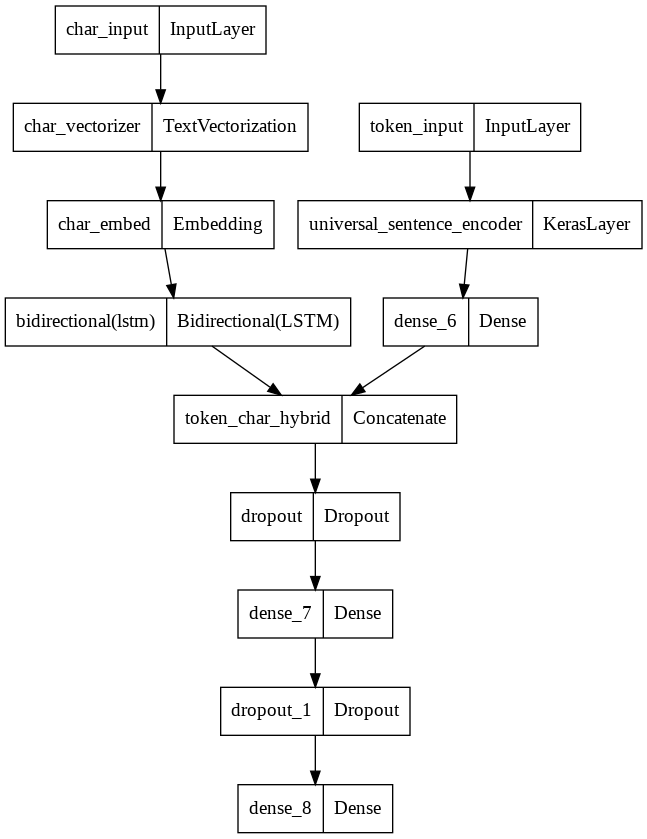

In [51]:
# Plot hybrid token and character model
from tensorflow.keras.utils import plot_model
plot_model(model_4)

In [52]:
# Compile token char model
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [53]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) 

# Repeat same steps validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Check out training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 8), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 8), dtype=tf.float64, name=None))>)

In [54]:
# Fit the model on tokens and chars
model_4_history = model_4.fit(train_char_token_dataset, # train on dataset of token and characters
                              steps_per_epoch=int(len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(len(val_char_token_dataset)))

Epoch 1/3
438/438 [==============================] - 48s 96ms/step - loss: 1.7865 - accuracy: 0.3263 - val_loss: 1.5960 - val_accuracy: 0.4210
Epoch 2/3
438/438 [==============================] - 33s 74ms/step - loss: 1.5960 - accuracy: 0.4216 - val_loss: 1.5582 - val_accuracy: 0.4470
Epoch 3/3
438/438 [==============================] - 36s 82ms/step - loss: 1.5487 - accuracy: 0.4387 - val_loss: 1.5414 - val_accuracy: 0.4520


In [55]:
# Make predictions using the token-character model hybrid
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

array([[0.06192776, 0.21872328, 0.02195026, ..., 0.02976397, 0.02518722,
        0.15197934],
       [0.11973734, 0.07620643, 0.1156015 , ..., 0.30032784, 0.06220797,
        0.11796628],
       [0.08130691, 0.11451942, 0.0532896 , ..., 0.11559943, 0.21473649,
        0.15398057],
       ...,
       [0.69092435, 0.08636861, 0.03383541, ..., 0.01482878, 0.01731243,
        0.08579562],
       [0.09976361, 0.45971906, 0.03364262, ..., 0.02789393, 0.15808609,
        0.11230802],
       [0.0868485 , 0.44185856, 0.02837387, ..., 0.01219789, 0.06889872,
        0.11134855]], dtype=float32)

In [56]:
# Turn prediction probabilities into prediction classes
model_4_preds = tf.argmax(model_4_pred_probs, axis=1) + 1
model_4_preds

<tf.Tensor: shape=(1000,), dtype=int64, numpy=
array([4, 6, 7, 1, 7, 3, 7, 1, 6, 5, 8, 8, 1, 8, 2, 8, 8, 1, 1, 1, 5, 5,
       8, 1, 1, 8, 5, 4, 2, 2, 2, 7, 8, 2, 4, 6, 4, 5, 8, 2, 6, 8, 1, 1,
       2, 8, 2, 7, 5, 1, 1, 2, 5, 5, 1, 1, 4, 6, 2, 1, 1, 2, 3, 8, 3, 1,
       8, 8, 4, 8, 7, 8, 6, 4, 2, 2, 4, 6, 2, 2, 2, 1, 5, 8, 4, 6, 1, 1,
       2, 4, 2, 8, 4, 2, 8, 1, 4, 1, 1, 5, 1, 1, 3, 1, 6, 1, 1, 7, 7, 7,
       8, 8, 1, 2, 1, 5, 5, 5, 4, 1, 2, 3, 2, 4, 7, 2, 1, 5, 7, 1, 5, 6,
       8, 2, 8, 1, 1, 1, 1, 2, 5, 2, 1, 1, 8, 8, 8, 6, 1, 1, 8, 7, 5, 1,
       1, 2, 6, 7, 5, 1, 6, 2, 2, 3, 4, 8, 2, 5, 3, 7, 2, 2, 7, 1, 1, 1,
       2, 6, 3, 6, 2, 5, 7, 3, 4, 8, 5, 5, 8, 5, 8, 1, 4, 4, 5, 8, 1, 7,
       1, 8, 1, 2, 1, 7, 1, 1, 8, 1, 2, 2, 7, 1, 2, 8, 5, 1, 2, 2, 1, 3,
       2, 2, 5, 1, 2, 2, 8, 1, 8, 2, 2, 4, 2, 1, 2, 5, 6, 7, 1, 3, 4, 1,
       3, 1, 2, 1, 3, 5, 8, 1, 2, 6, 7, 3, 1, 8, 6, 5, 5, 1, 2, 2, 1, 4,
       3, 6, 4, 8, 2, 8, 1, 6, 2, 8, 2, 2, 1, 2, 8, 8, 1, 1, 1, 8, 8, 8,
    

In [57]:
# Get results of token-char-hybrid model
model_4_results = calculate_results(y_true=val_labels,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 45.2,
 'f1': 0.4446184585960079,
 'precision': 0.4470333117936599,
 'recall': 0.452}

## Compare model results

In [58]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"custom_token_embed_conv1d": model_1_results,
                                  "pretrained_token_embed": model_2_results,
                                  "custom_char_embed_conv1d": model_3_results,
                                  "hybrid_char_token_embed": model_4_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
custom_token_embed_conv1d,35.8,0.355990,0.358,0.354204
pretrained_token_embed,45.1,0.449039,0.451,0.443325
custom_char_embed_conv1d,29.7,0.289892,0.297,0.241005
hybrid_char_token_embed,45.2,0.447033,0.452,0.444618


## Prediction - Model 2

In [59]:
# Save best performing model to SavedModel format
model_2.save("tf_universal_sentence_model")

INFO:tensorflow:Assets written to: tf_universal_sentence_model/assets


INFO:tensorflow:Assets written to: tf_universal_sentence_model/assets


In [60]:
model_path = "/content/tf_universal_sentence_model"

# Load downloaded model from Google Storage
loaded_model = tf.keras.models.load_model(model_path)

In [61]:
# Converting test_set sentences
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences))
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [62]:
# Make predictions on the test dataset
test_pred_probs = loaded_model.predict(test_dataset,
                                       verbose=1)
test_preds = tf.argmax(test_pred_probs, axis=1) +1

# Inserting the emotion column in test_set dataframe
test_df['emotion'] = test_preds

# Save to csv
test_df.to_csv(r'/content/test_set_predicted.txt', index=False, sep='\t')

test_df

63/63 [==============================] - 1s 9ms/step


,sentence,emotion
0,"Come , let's go get that automobile .",2
1,"Well , some other time , then ?",2
2,He's in trouble . Boy ?,3
3,Criminal gang unit to take control .,4
4,By Molto . No discussion . Interview .,1
...,...,...
1995,Let's do some good .,2
1996,"Hey , you're looking good .",5
1997,"Have they moved the embassy , or are you hijac...",7
1998,What that !,1


[1 2 3 4 5 6 7 8]


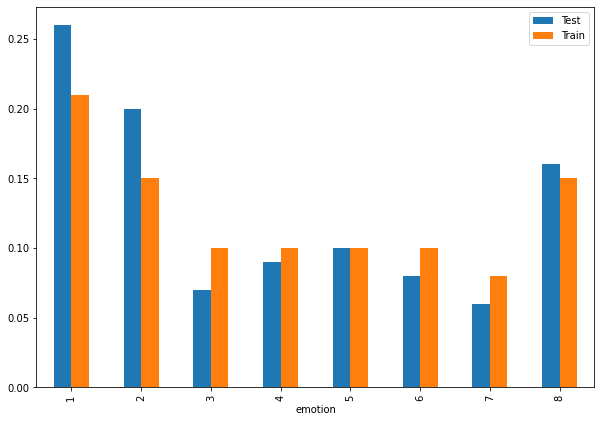

In [84]:
# check the emotions defined:
print(np.sort(test_df['emotion'].unique()))

# check the distribution of sentences in each emotion class:
dft = test_df.groupby('emotion').count().reset_index()
sum_total = dft['sentence'].sum()
dft['perc_total'] = round(dft['sentence']/sum_total,2)
dft['dataset'] = 'Test'
df = df.append(dft)

df_plt = df.pivot(index='emotion', columns='dataset', values='perc_total')

# Plot and compare class distribution of the datasets
df_plt.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0))

plt.show()